# Colab Notebook for SAM2 segmentation

Author: Dr.Yusuke Kimata (ORCID: https://orcid.org/0000-0002-1366-0636)<br>
ref: Notebook by Meta Research (https://github.com/facebookresearch/sam2/blob/main/notebooks/)<br>

### **Revision for flexible reference frame selection (2025/09/22)**
For initial segmentation, you can select not only the first frame but also any other frame as the reference.

### **Revision for new model SAM 2.1 (2025/02/05)**
Release Note (https://github.com/facebookresearch/sam2/blob/main/RELEASE_NOTES.md)


This notebook is for segmentation of time-lapse image with SAM2

Set `/content/drive/MyDrive/Colab Notebooks/SAM2-segmentation/` as the working directory.<br>
Place the JPEG files, each corresponding to a separate frame, into the input directory.  <br>
Only JPEG files with numeric filenames can be processed as input (e.g., `000.jpg`, `001.jpg`, ...).  <br>
Make sure to change the runtime type to **"GPU"**

## Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/

import os
HOME = os.getcwd()
print("HOME:", HOME)

using_colab = True
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    #!git clone https://github.com/facebookresearch/sam2.git # Comment out this line on subsequent runs

Mounted at /content/drive
/content/drive/MyDrive
HOME: /content/drive/MyDrive
PyTorch version: 2.8.0+cu126
Torchvision version: 0.23.0+cu126
CUDA is available: True


In [2]:
%cd {HOME}/sam2

/content/drive/MyDrive/sam2


In [3]:
!pip install -q supervision
!pip install -q hydra-core
!pip install -q iopath
!pip install -q jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.6 MB/s eta 0:00:00


### Download SAM2 checkpoints

**NOTE:** SAM2.1 is available in 4 different model sizes ranging from the lightweight "sam2.1_hiera_tiny" (38.9M parameters) to the more powerful "sam2.1_hiera_large" (224.4M parameters).

In [ ]:
# Not required on subsequent runs
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt -P {HOME}/checkpoints

### Import libraries

In [4]:
import cv2
import torch
import base64

import json

import numpy as np
import supervision as sv

import matplotlib.pyplot as plt
from glob import glob
from natsort import natsorted
from google.colab.patches import cv2_imshow

from pathlib import Path
from supervision.assets import download_assets, VideoAssets
from sam2.build_sam import build_sam2_video_predictor

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

from tqdm import tqdm

IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

**NOTE:** This code enables mixed-precision computing for faster deep learning. It uses bfloat16 for most calculations and, on newer NVIDIA GPUs, leverages TensorFloat-32 (TF32) for certain operations to further boost performance.

In [5]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

### Prepare functions

In [6]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

# Function to visualize a mask
def show_mask(mask, ax, obj_id=None):
    cmap = plt.get_cmap("tab10")
    cmap_idx = 0 if obj_id is None else obj_id
    color = np.array([*cmap(cmap_idx)[:3], 0.3])

    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

# Function to visualize prompt points
def show_points(coords, labels, ax, marker_size=30):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='o', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='x', s=marker_size, linewidth=1.25)

# Function to visualize prompt boxes
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

# Function to overlay a mask on the original image
def show_mask_cv2(image, mask, obj_id=None):
    cmap = plt.get_cmap("tab10")
    cmap_idx = 0 if obj_id is None else obj_id
    color = np.array([*cmap(cmap_idx)[:3], 0.3]) * 255
    h, w = mask.shape[-2:]

    mask_image = (mask.reshape(h, w, 1) * color[:3]).astype(np.uint8)

    overlay = cv2.addWeighted(image, 1, mask_image, 0.2, 0)
    return overlay

# Function to save a mask as an 8-bit grayscale image
def save_mask_grayscale(mask, output_path):
    h, w = mask.shape[-2:]

    mask_image = (mask.reshape(h, w) * 255).astype(np.uint8)

    cv2.imwrite(output_path, mask_image)

# Fuction for propagation of inference state
def collect_results(gen, video_segments):
    for f_idx, obj_ids, logits in gen:
        video_segments.setdefault(f_idx, {})
        for i, oid in enumerate(obj_ids):
            video_segments[f_idx][oid] = (logits[i] > 0).cpu().numpy()

## Load model

In [7]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2.1_hiera_large.pt"
CONFIG = "configs/sam2.1/sam2.1_hiera_l.yaml"

## Segmentation

In [8]:
# Prepare model
predictor = build_sam2_video_predictor(CONFIG, CHECKPOINT)

In [9]:
# Input, output directory name
input_name = "input_MT_demo"
output_name = "output_MT_demo"

input_img_dir = "/content/drive/MyDrive/Colab Notebooks/SAM2-segmentation/" + input_name + "/"
output_mask_dir = "/content/drive/MyDrive/Colab Notebooks/SAM2-segmentation/" + output_name + "_mask/"
output_merged_dir = "/content/drive/MyDrive/Colab Notebooks/SAM2-segmentation/" + output_name + "_merged/"

# Create the directory if it does not exist
os.makedirs(input_img_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)
os.makedirs(output_merged_dir, exist_ok=True)

# Check
print(f"Input directory: {os.path.exists(input_img_dir)}")
print(f"Mask directory: {os.path.exists(output_mask_dir)}")
print(f"Merged directory: {os.path.exists(output_merged_dir)}")

Input directory: True
Mask directory: True
Merged directory: True


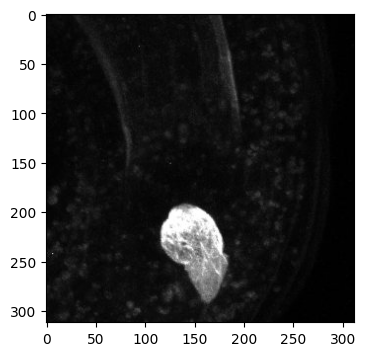

In [10]:
# Get the first frame of the video
frame_names = natsorted(glob(f"{input_img_dir}*.jpg"))
img = cv2.imread(frame_names[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Visualization
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis('on')
plt.show()

### Initialize the inference state

**NOTE:** SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an inference state on this video. During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [11]:
# Always run this code before processing a new video
inference_state = predictor.init_state(video_path=input_img_dir)

frame loading (JPEG): 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


**NOTE:** If you have run any previous tracking using this inference_state, please reset it first via reset_state. (The cell below is just for illustration; it's not needed to call reset_state here as this inference_state is just freshly initialized above.)

In [22]:
# Always run this before processing a new video
predictor.reset_state(inference_state)

### Prompting with points

In [13]:
OBJECTS = ['object', 'bg'] # Define target object as 'object' and background as 'bg'

**NOTE:** Let's choose the index of the reference frame that we will use to annotate the objects we are looking for.

In [23]:
FRAME_IDX = 10 # Set the frame idx of reference for initial segmentation
OBJECT_ID = 1
FRAME_PATH = f"{input_img_dir}{FRAME_IDX:03d}.jpg"

widget = BBoxWidget(classes=OBJECTS)
widget.image = encode_image(FRAME_PATH)
widget
# Click on several points in the displayed widget to indicate the object to segment and the background.
# Don't worry if the displayed points appear slightly misaligned.

BBoxWidget(classes=['object', 'bg'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',…

In [24]:
# Retrieve bounding box coordinates from widget.bboxes
coordinates = widget.bboxes

# Generate a filename using the name of the input directory
dir_name = os.path.basename(os.path.normpath(input_img_dir))  # Extract only the directory name
os.makedirs("/content/drive/MyDrive/Colab Notebooks/SAM2-segmentation/prompts/", exist_ok=True)
output_file = "/content/drive/MyDrive/Colab Notebooks/SAM2-segmentation/prompts/" + f'coordinates_{dir_name}_frame{FRAME_IDX}.txt'

# Save the coordinates to a text file
with open(output_file, 'w') as file:
    # Write the FRAME_PATH as the first line
    file.write(f'FRAME_PATH = "{FRAME_PATH}"\n')

    # Save the coordinate data in JSON format
    json.dump(coordinates, file, indent=4)

In [ ]:
widget.bboxes # Copy the output to 'default_box' in the next cell, or skip this cell.

In [25]:
default_box = []

boxes = widget.bboxes if widget.bboxes else default_box
input_point = np.array([
    [
        box['x'],
        box['y']
    ] for box in boxes
])
# Assign 0 to the 'bg' label and 1 to all other labels
input_label = np.array([
    0 if box['label'] == 'bg' else 1 for box in boxes
])

In [26]:
# Perform segmentation on the specified frame using the input prompts
_, out_obj_ids, out_mask_logits = predictor.add_new_points(
    inference_state=inference_state,
    frame_idx=FRAME_IDX,
    obj_id=OBJECT_ID,
    points=input_point,
    labels=input_label,
)

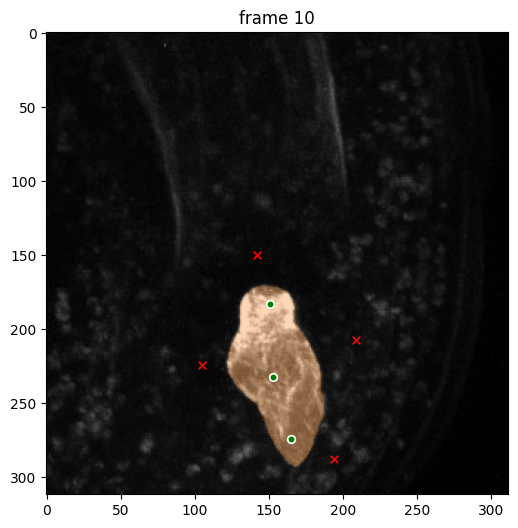

In [27]:
# Visualize the result
plt.figure(figsize=(6, 6))
plt.title(f"frame {FRAME_IDX}")
image = cv2.imread(frame_names[FRAME_IDX])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

In [28]:
# Run segmentation on all frames of the video
video_segments = {}

# Forward (FRAME_IDX→last)
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(
        inference_state,
        start_frame_idx=FRAME_IDX,
        reverse=False
    ):
    if out_frame_idx not in video_segments:
        video_segments[out_frame_idx] = {}
    for i, out_obj_id in enumerate(out_obj_ids):
        video_segments[out_frame_idx][out_obj_id] = (out_mask_logits[i] > 0).cpu().numpy()

# Backward (FRAME_IDX→start）)
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(
        inference_state,
        start_frame_idx=FRAME_IDX,
        reverse=True
    ):
    if out_frame_idx not in video_segments:
        video_segments[out_frame_idx] = {}
    for i, out_obj_id in enumerate(out_obj_ids):
        video_segments[out_frame_idx][out_obj_id] = (out_mask_logits[i] > 0).cpu().numpy()

propagate in video: 100%|██████████| 11/11 [00:10<00:00,  1.01it/s]


frame 0


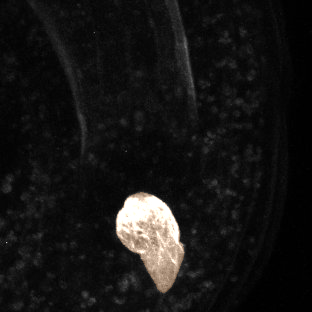

frame 5


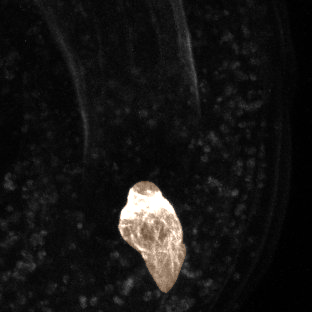

frame 10


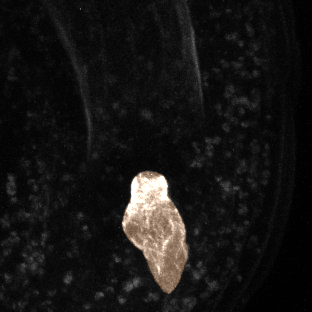

frame 15


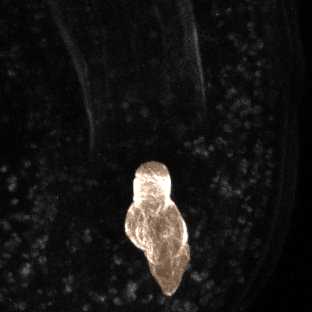

frame 20


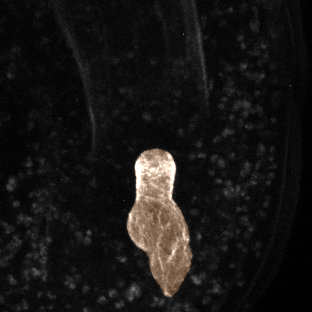

frame 25


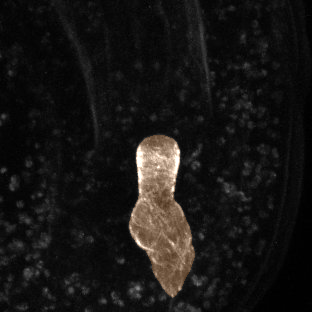

frame 30


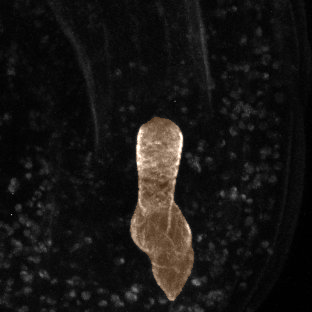

frame 35


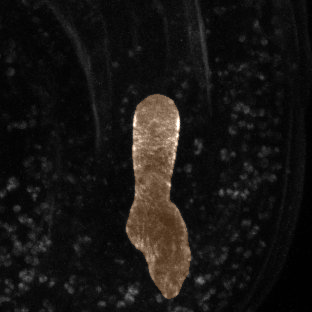

frame 40


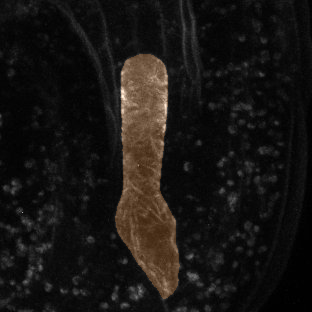

frame 45


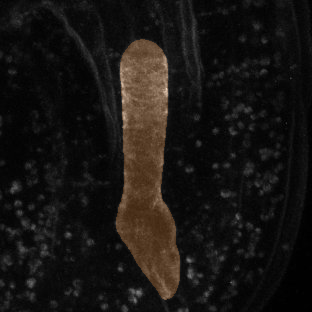

frame 50


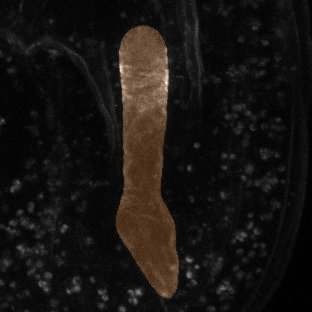

In [29]:
# Display every few frames to check the results
vis_frame_stride = 5 # step interval

plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    image = cv2.imread(frame_names[out_frame_idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        image = show_mask_cv2(image, out_mask, obj_id=out_obj_id)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        print(f"frame {out_frame_idx}")
        cv2_imshow(image)

## Addition of Reference Frames (Optional)

In [ ]:
# Retrieve a different frame from the video
FRAME_IDX2 = 25
OBJECT_ID = 1
img2 = cv2.imread(frame_names[FRAME_IDX2])
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Visualization
plt.figure(figsize=(4, 4))
plt.imshow(img2)
plt.axis('on')
plt.show()

In [ ]:
FRAME_PATH2 = f"{input_img_dir}{FRAME_IDX2:03d}.jpg"

widget2 = BBoxWidget(classes=OBJECTS)
widget2.image = encode_image(FRAME_PATH2)
widget2
# Click on several points in the displayed widget to indicate the object to segment and the background.
# Don't worry if the displayed points appear slightly misaligned.

In [ ]:
# Retrieve bounding box coordinates from widget2.bboxes
coordinates = widget2.bboxes

# Generate a filename using the name of the input directory
dir_name = os.path.basename(os.path.normpath(input_img_dir))  # Extract directory name only
output_file = "/content/drive/MyDrive/Colab Notebooks/SAM2-segmentation/prompts/" + f'coordinates_{dir_name}_frame{FRAME_IDX2}_.txt'

# Save the coordinates to a text file
with open(output_file, 'w') as file:
    # Write the FRAME_PATH as the first line
    file.write(f'FRAME_PATH = "{FRAME_PATH2}"\n')

    # Save the coordinate data in JSON format
    json.dump(coordinates, file, indent=4)

In [ ]:
default_box = []

boxes = widget2.bboxes if widget2.bboxes else default_box
input_point = np.array([
    [
        box['x'],
        box['y']
    ] for box in boxes
])
# Assign 0 to the 'bg' label and 1 to all other labels
input_label = np.array([
    0 if box['label'] == 'bg' else 1 for box in boxes
])

_, out_obj_ids, out_mask_logits = predictor.add_new_points(
    inference_state=inference_state,
    frame_idx=FRAME_IDX2,
    obj_id=OBJECT_ID,
    points=input_point,
    labels=input_label,
)

In [ ]:
plt.figure(figsize=(6, 6))
plt.title(f"frame {FRAME_IDX2}")
image = cv2.imread(frame_names[FRAME_IDX2])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

In [ ]:
# Run segmentation on all frames of the video
video_segments = {}

collect_results(
    predictor.propagate_in_video(inference_state,
                                 start_frame_idx=FRAME_IDX2,
                                 reverse=False),
    video_segments
)

collect_results(
    predictor.propagate_in_video(inference_state,
                                 start_frame_idx=FRAME_IDX2,
                                 reverse=True),
    video_segments
)

In [ ]:
# Display every few frames to check the results
vis_frame_stride = 5 # step interval

plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    image = cv2.imread(frame_names[out_frame_idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        image = show_mask_cv2(image, out_mask, obj_id=out_obj_id)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        print(f"frame {out_frame_idx}")
        cv2_imshow(image)

## Save results as mask images



### (Option1) Saving the Masks in Grayscale

In [30]:
for out_frame_idx in tqdm(range(len(frame_names)), desc="Saving masks"):
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        basename = os.path.basename(frame_names[out_frame_idx])
        output_frame = os.path.join(output_mask_dir, basename)

        # Save the mask as an 8-bit grayscale image
        save_mask_grayscale(out_mask, output_frame)

Saving masks: 100%|██████████| 55/55 [00:00<00:00, 156.60it/s]


### (Option2) Saving Overlayed Masks on Original Images

In [31]:
for out_frame_idx in tqdm(range(len(frame_names)), desc="Saving overlayed images"):
    # Load the original image
    image = cv2.imread(frame_names[out_frame_idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Overlay masks onto the image
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        image = show_mask_cv2(image, out_mask, obj_id=out_obj_id)

    # Prepare output path
    basename = os.path.basename(frame_names[out_frame_idx])
    output_frame = os.path.join(output_merged_dir, basename)

    # Save the resulting image
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_frame, image)

Saving overlayed images: 100%|██████████| 55/55 [00:00<00:00, 68.34it/s]
